<a href="https://colab.research.google.com/github/antoniivanov/vdk-demo/blob/main/ingest-anonymize-workshop/IngestAndAnonymizeWorkshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Ingest and Anonymize Workshop

In the era of Big Data, it's crucial to maintain the privacy and security of sensitive data. This notebook provides a guide on how to ingest user data, anonymize some parts of it, and store it in a relational database, using the [Versatile Data Kit (VDK)](https://github.com/vmware/versatile-data-kit)



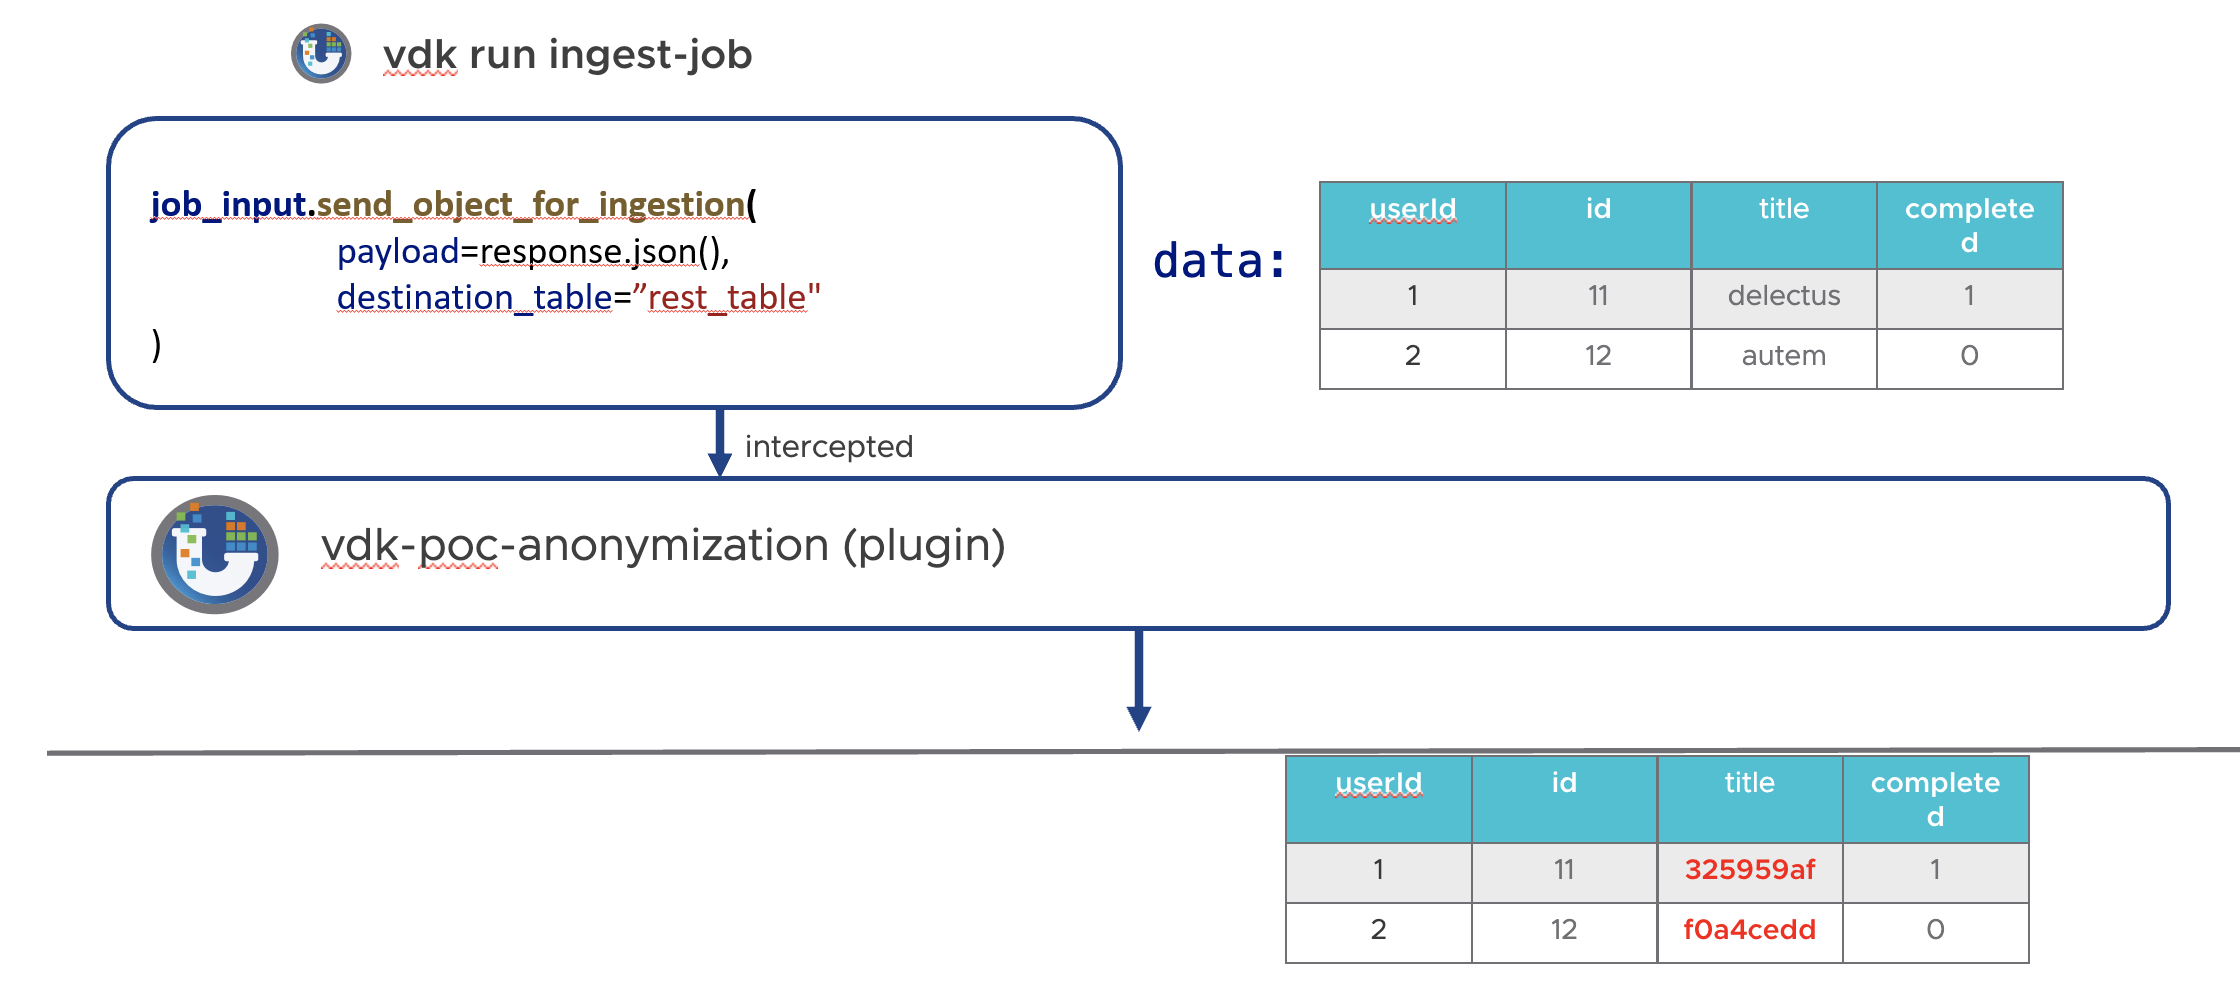

## 1. Prerequisites

### 1.1 Good to Know Before You Start


This tutorial is designed to be accessible, but you'll find it easier if you're familiar with:

- **Python and SQL**: Basic commands and queries.
- **Data Concepts**: Simple data modeling and API usage.
- **Tools**: Comfort with command line and Jupyter Notebook

### 1.2 Useful notebook shortcuts


* Click the **Play icon** in the left gutter of the cell;
* Type **Cmd/Ctrl+Enter** to run the cell in place;
* Type **Shift+Enter** to run the cell and move focus to the next cell (adding one if none exists); or
* Type **Alt+Enter** to run the cell and insert a new code cell immediately below it.

There are additional options for running some or all cells in the **Runtime** menu on top.


### 1.3 Install Versatile Data Kit and enable plugins

In [ ]:
!pip install quickstart-vdk vdk-notebook vdk-ipython

## 2. Configuration

In [ ]:
%env DB_DEFAULT_TYPE=sqlite
%env INGEST_METHOD_DEFAULT=sqlite
%env INGESTER_WAIT_TO_FINISH_AFTER_EVERY_SEND=true

## 3. Initialize new VDK job (input)

In [ ]:
"""
vdk.plugin.ipython extension introduces a magic command for Jupyter.
The command enables the user to load VDK for the current notebook.
VDK provides the job_input API, which has methods for:
    * executing queries to an OLAP database;
    * ingesting data into a database;
    * processing data into a database.
Type help(job_input) to see its documentation.

"""
%reload_ext vdk.plugin.ipython
%reload_VDK
job_input = VDK.get_initialized_job_input()

In [ ]:
help(job_input)

### 3.1 Explore what you can do

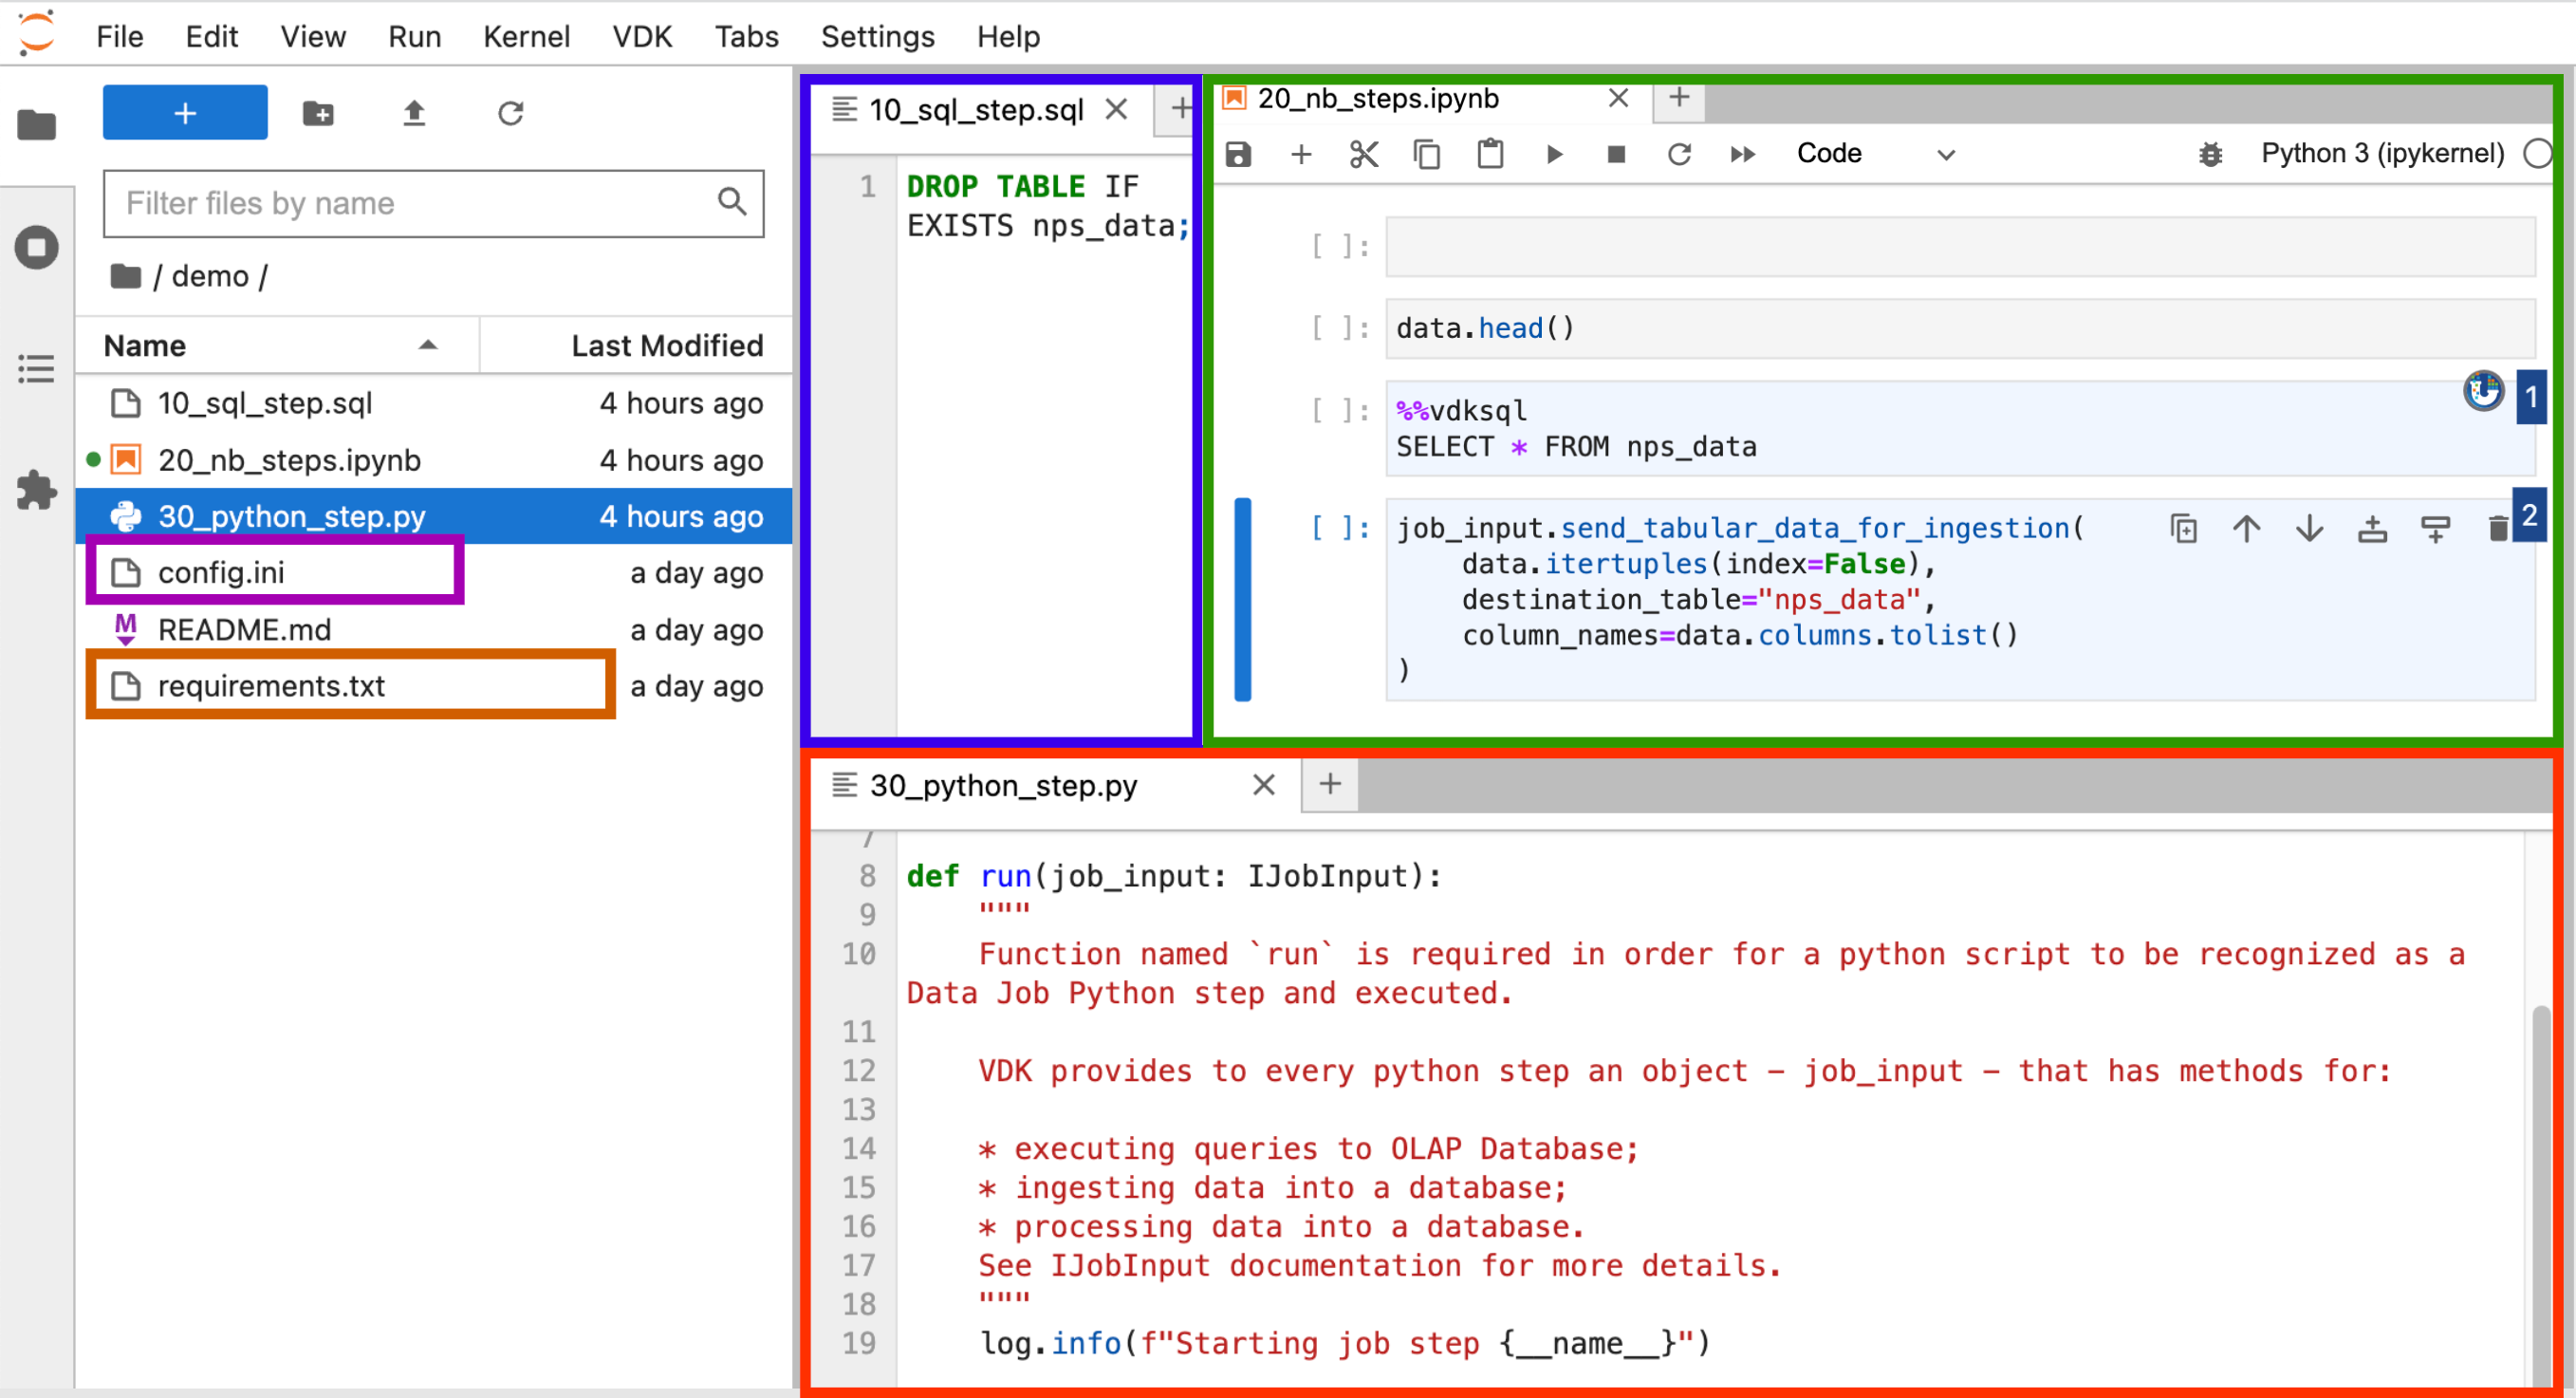

#### 3.1.1 Access job arguments



In [ ]:
print(job_input.get_arguments())

#### 3.1.2 Ingest data

In [ ]:
job_input.send_tabular_data_for_ingestion(rows=[[1,2], [11, 22]], destination_table = "dummy_sent_data", column_names = ['column_1', 'column_2'])

job_input.send_object_for_ingestion(payload={"column_1": 88, "column_2": 99}, destination_table="dummy_sent_data")

#### 3.1.3 Execute SQL Queries

In [ ]:
%%vdksql
select * from dummy_sent_data

#### 3.1.4 Manage state properties or secrets

In [ ]:
import time
job_input.set_all_properties({"last_time_run": time.time()})
job_input.set_all_secrets({ "secret": "my secret" })

print(job_input.get_all_properties())

## 4. Ingesting Users data

**Ingest** user data from HTTP API (https://jsonplaceholder.typicode.com/users) into a database (sqlite in this case)

In [ ]:
url="https://jsonplaceholder.typicode.com/users"

In [ ]:
# TODO:
# HINT: used job_input.send.... methods

In [ ]:
%%vdksql
# TODO : inspect the data

## Anonymization Plugin

- The plugin should be configurable using `anonymization_fields={table_name: [columns], ...}`

- Upon installation it will anonymized above fields


To get started we can see See https://github.com/vmware/versatile-data-kit/tree/main/projects/vdk-plugins



### Generate a VDK Plugin package project

In [ ]:
!pip install -U cookiecutter

In [ ]:
!cookiecutter https://github.com/tozka/cookiecutter-vdk-plugin.git


**Open Files tab on the left , you should see newly created directory looking like this:**

** Open plugin_entry.py . You will be editing this file **

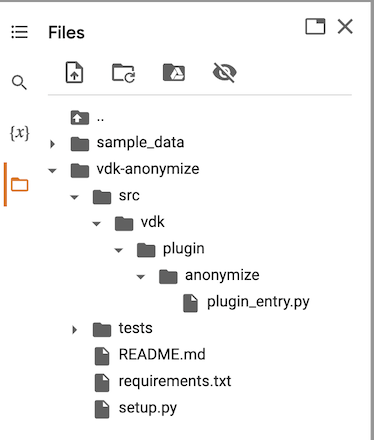

### Implement Pre Ingest Process Hook

See [Ingester hooks documentation at here](https://github.com/vmware/versatile-data-kit/blob/7fba4f7c5c4da968e80d6a562b44517433b76e73/projects/vdk-core/src/vdk/api/plugin/plugin_input.py#L230)

We will implement AnonymizationIngesterPlugin class like that:

```python
class AnonymizationIngesterPlugin(IIngesterPlugin):
    def __init__(
        self, anonymization_fields: Dict[str, List[str]] ) -> None:
        self._anonymization_fields = anonymization_fields

    # inherited
    def pre_ingest_process(
        self,
        payload: List[dict],
        destination_table: Optional[str] = None,
        target: Optional[str] = None,
        collection_id: Optional[str] = None,
        metadata: IngestionMetadata = None,
    ) -> Tuple[List[Dict], Optional[IngestionMetadata]]:
        # TODO: your implementation
```

### What configuration your plugin needs?  

Edit plugin_entry.py and add `vdk_configure` hook

It should accept list of tables and fields to anonymize

Implement [vdk_configure hook](https://github.com/vmware/versatile-data-kit/blob/main/projects/vdk-core/src/vdk/api/plugin/core_hook_spec.py#L76)

Let's add field `anonymization_fields` which would be of type `Dict[str, list]` key can be table name and value is list of columns ot obfuscate.

```python
def vdk_configure(self, config_builder: "ConfigurationBuilder") -> None:
        """
         Add new configuration keys and values.
      
        Example::

         config_builder.add(
                  key="key_name",
                  default_value="",
                  description="Key Description",
          )

        Or set the value of configuration key

        Example::

          config_builder.set_value("key_name", "value")
        """
```

### Initialize and register the ingester hooks

Copy this in plugin_entry.py

```python
@hookimpl
def initialize_job(context: JobContext) -> None:
    # Let's get the correctly configured value
    anonymization_fields = context.core_context.configuration.get_value(
        "anonymization_fields"
    )
    anonymization_fields = json.loads(anonymization_fields)
    context.ingester.add_ingester_factory_method(
        "anonymize",
        lambda: AnonymizationIngesterPlugin(anonymization_fields),
    )
```

### Install the newly build plugin

In [ ]:
!pip install -e vdk-anonymize # or whichever name you chose

**Restart the runtime** to load the new package:

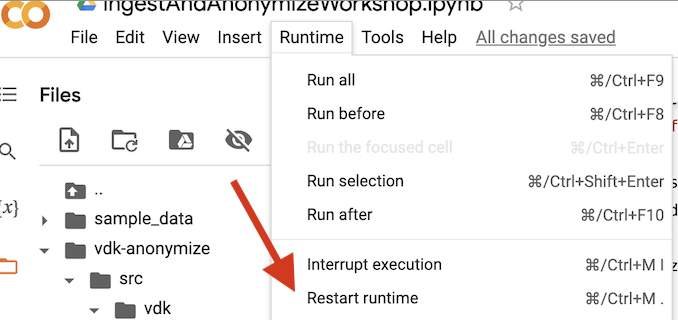

### Configure the new plugin

In [ ]:
# The same as above
%env DB_DEFAULT_TYPE=sqlite
%env INGEST_METHOD_DEFAULT=sqlite
%env INGESTER_WAIT_TO_FINISH_AFTER_EVERY_SEND=true

# The new configuraiton:
%env anonymization_fields = { "users": ["name", "username", "email"] }
%env ingest_payload_preprocess_sequence=anonymize

# Reload as above:
%reload_ext vdk.plugin.ipython
%reload_VDK --log-level-vdk DEBUG
job_input = VDK.get_initialized_job_input()

### Test and verify

Go back to step **4. Ingesting Users data**

<br/>

## Solutions



<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>


### The ingestion

In [ ]:
import pandas as pd
import requests

data = requests.get(url).json()

# Flatten nested dictionaries
flattened_df = pd.json_normalize(data, sep='_')

job_input.send_tabular_data_for_ingestion(
        flattened_df.itertuples(index=False),
        destination_table="users",
        column_names=flattened_df.columns.tolist(),
    )

### The plugin implemented

Below is plugin implementation. You can compare it to your own or copy-paste it in plugin_entry.py if it's too hard








In [ ]:

import logging
from typing import Any
from typing import Dict
from typing import List
from typing import Optional
from typing import Tuple

from vdk.api.plugin.hook_markers import hookimpl
from vdk.api.plugin.plugin_input import IIngesterPlugin
from vdk.internal.builtin_plugins.run.job_context import JobContext
from vdk.internal.core.config import ConfigurationBuilder

from vdk.api.plugin.plugin_input import IIngesterPlugin

import json

IngestionMetadata = IIngesterPlugin.IngestionMetadata

log = logging.getLogger(__name__)


"""
Ingester Plugins are implemented by inheriting IIngesterPlugin and impelemented only the needed methods.
See IIngesterPlugin docs for more info.
"""

@hookimpl(tryfirst=True)
def vdk_configure(config_builder: ConfigurationBuilder) -> None:
    # Declare needed configuration, it will be injected automatically fron file, env variables, etc.
    config_builder.add(
        key="anonymization_fields",
        default_value='{"table_name": ["column_name"]}',
        description="Map with entity/table name and list of attributes names that need to be anonymized."
        "Checks are case sensitive.",
    )


@hookimpl
def initialize_job(context: JobContext) -> None:
    # Now let's get the correctly configured value
    anonymization_fields = context.core_context.configuration.get_value(
        "anonymization_fields"
    )
    anonymization_fields = json.loads(anonymization_fields)
    log.info(f"Anonymization fields: {anonymization_fields}")
    context.ingester.add_ingester_factory_method(
        "anonymize",
        lambda: AnonymizationIngesterPlugin(anonymization_fields),
    )
    log.info(f"ingester keys: {context.ingester._ingester_builders.keys()}")



class AnonymizationIngesterPlugin(IIngesterPlugin):
    def __init__(
        self, anonymization_fields: Dict[str, List[str]] ) -> None:
        self._anonymization_fields = anonymization_fields

    def _anonymize_if_needed(self, destination_table: str, key: str, value: Any):
        table = destination_table if destination_table else ""
        if (
            key
            and table in self._anonymization_fields
            and key in self._anonymization_fields[table]
        ):
            return self._anonymize(value)
        else:
            return value

    def _anonymize(self, value):
      import hashlib
      return hashlib.sha256(f"{value}".encode()).hexdigest()[0:30]


    # inherited
    def pre_ingest_process(
        self,
        payload: List[dict],
        destination_table: Optional[str] = None,
        target: Optional[str] = None,
        collection_id: Optional[str] = None,
        metadata: IngestionMetadata = None,
    ) -> Tuple[List[Dict], Optional[IngestionMetadata]]:
        if self._anonymization_fields:
            payload = [
                {
                    k: self._anonymize_if_needed(destination_table, k, v)
                    for (k, v) in item.items()
                }
                for item in payload
            ]
        return payload, metadata
